<a href="https://colab.research.google.com/github/okonp07/USING-STATISTICAL-DISTRIBUTIONS-TO-MODEL-STOCK-RETURNS/blob/main/USING_STATISTICAL_DISTRIBUTIONS_TO_MODEL_STOCK_RETURNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# USING STATISTICAL DISTRIBUTIONS TO MODEL STOCK RETURNS

*We looked at various ways to measure risk and returns in the last lesson. Here, we take that a step further by using distributions to correctly model risk and returns.*

In [1]:
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt
from scipy import stats

yfin.pdr_override()

c

In [2]:
# start = datetime.date.today() - datetime.timedelta(365 * 20)
# end = datetime.date.today()
end = datetime.date(2021, 11, 20)
start = end - datetime.timedelta(365 * 20)

prices = pd.DataFrame(web.DataReader(["^GSPC"], start, end)["Adj Close"])

# Rename column to make names more intuitive
prices = prices.rename(columns={"Adj Close": "SP500"})
df = np.log(prices) - np.log(prices.shift(1))
df = df.iloc[1:, 0:]

[*********************100%***********************]  1 of 1 completed


### 1.1 Are returns symmetric?

One quick way of doing this is to determine how many data points we have on either side of the mean here. We have a bit more then 5,000 data points here. The below code takes the count of data points greater than the mean and divides it by the total data points. This will give us the percentage of data points greater than the mean

In [3]:
(len(df[df.SP500 > df.SP500.mean()])) / (len(df))

0.5262321144674086

We're getting about 52.6% of data points being greater than the mean, which shows we have a slightly negative skew to this dataset. We can't rule out symmetric returns based on this since it is only a sample of data and is reasonably close to the 50% mark. This makes it hard to say for certain whether S&P 500 returns are symmetric or not, but it is still a reasonable assumption to make here. Also, keep in mind there should be a slight bias towards positive returns anyways, if for no other reason than some drift from inflation.

### 1.2 Is Volatility constant?

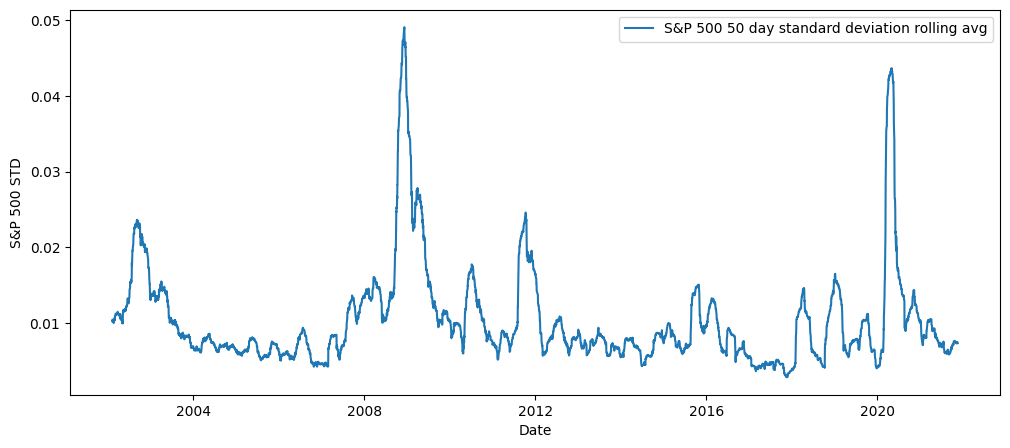

In [4]:
vols = pd.DataFrame(df.SP500.rolling(50).std()).rename(columns={"SP500": "S&P 500 STD"})

# set figure size
plt.figure(figsize=(12, 5))

# plot using rolling average
sns.lineplot(
    x="Date",
    y="S&P 500 STD",
    data=vols,
    label="S&P 500 50 day standard deviation rolling avg",
)
plt.show()

Above, we calculate a rolling average of the standard deviation and then make a line chart of it. It can be clearly seen that volatility is anything but constant. This adds another layer of complexity to modeling stock returns, especially the many models which assume constant volatility

## 2. Are Stock Returns Normally Distributed?
The normal distribution is one of the most common distributions used in modeling random variables. Indeed, many phenomena in the natural and social sciences can be modeled by normal distribution. One of the great advantages of the normal distribution is its simplicity. We can completely describe a normal distribution through two numbers: one for the center of the distribution and one for the uncertainty about that center. The first number refers to the mean, and the second number refers to the standard deviation.

Once we have these two numbers, we can draw inferences, estimate percentiles, compute probabilities that a point falls within a region, and more. If our data is well-represented by the normal distribution, then we can confidently use the mean and standard deviation to report our portfolio expected returns and volatilities. If our data is not well represented by the normal distribution, then we need to find other distributions that are more suitable. Thus, when we have a distribution of stock returns, for example, we'll want to start this assessment by visualizing the returns to see if they appear to be normal. Of course, we can follow this up with more quantitative assessments by running statistical tests.

We can visualize the data using the hist() method. We pass in bins = 100 as a parameter to determine the amount of buckets to place the data in. The more bins you have, the more granular the data will look in a histogram. Increasing the bins too much may result in slightly noisy data, which will make it tougher to determine a normal distribution. The chart in Figure 3 looks like it could be normally distributed, but we need to be a little more scientific to determine if that's actually the case or not.

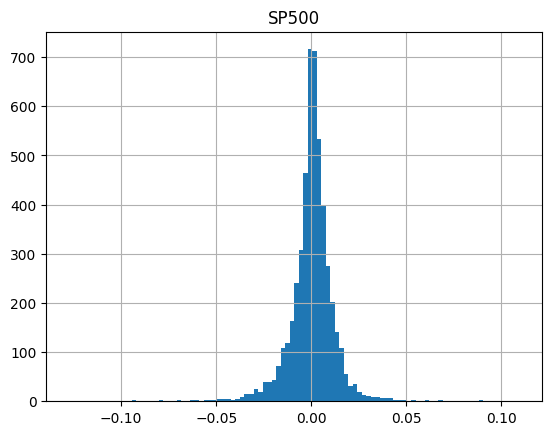

In [5]:
df.hist(bins=100);

### 2.1 Conducting a normality test

In [6]:
stats.normaltest((np.array(df.SP500)))

NormaltestResult(statistic=1157.9334577500736, pvalue=3.613636331694425e-252)

We can use the `normaltest()` method here to determine if the sample data could fit a normal distribution. This method uses D’Agostino and Pearson’s normality test, which combines skew and kurtosis to produce an omnibus test of normality.

The null hypothesis of this test is that the sample data fits a normal distribution. Let's assume we want to be 90% confident this data fits a normal distribution. We can compare this to the p-value to see if it's greater than 90%. In this case, the value, 2.43e-252, is extremely small, which leads us to reject the null hypothesis that this data fits a normal distribution.


### 2.2 Testing Skewness and Kurtosis
As one added testing step, we can test the skewness and kurtosis of our distribution using the Jarque-Bera test. The test statistic will always be greater than zero. The further the test statistic is from zero, the more likely the sample data does not match a normal distribution.

Lucky for us, Python has another library for us to use here which really simplifies the analysis. From the `scipy.stats` library, we can use the `jarque_bera()` method directly to our data to get test statistic 


In [7]:
stats.jarque_bera((np.array(df.SP500))).pvalue

0.0

The p value of our data here shows once and for all that there is virtually zero chance our sample data is normally distributed

### 2.3 Where Does Our Gaussian Distribution Break Down?
So according to the normality test, our data is not normally distributed despite the histogram looking like it may be. So, why is the data failing the normality test? The answer likely comes down to fat tails. Fat tails essentially means that extreme events +/-3 standard deviations away from the mean) are more likely than the normal distribution would imply.

Assuming a normal distribution with a mean of 0.00028 and standard deviation of 0.012, we can determine the probability of any return given that the returns fit a normal distribution.

To determine how many standard deviations away from the mean a specific number is, we need to use 

$$\frac{X - \bar{X}}{\text{Sample standard deviation}}$$

 Let's do this for the min and max of the sample data:

In [8]:
dfMax = df.SP500.max()
dfMin = df.SP500.min()
print(
    "Min return of sample data is %.4f and the maximum return of sample data is %.4f"
    % (dfMin, dfMax)
)

Min return of sample data is -0.1277 and the maximum return of sample data is 0.1096


In [9]:
df.SP500.max()

0.10957196759533883

In [10]:
df.SP500.min()

-0.12765219747281709

In [11]:
(df.SP500.min() - df.SP500.mean()) / df.SP500.std()

-10.454892010611209

In [12]:
(df.SP500.max() - df.SP500.mean()) / df.SP500.std()

8.931814347341954

Over the last 20 years, S&P 500 has had a maximum daily return of 10.96% and a minimum daily return of -12.77%. If we use the formula to determine standard deviations from the mean, we get -10.5 and 8.9 standard deviations away from the mean for the minimum and maximum, respectively. These standard deviations are humongous when compared to the normal distribution. We can see this analytically when we plug in the z score to the `norm.cdf()` method to determine the probability this value could be in a normal distribution:

In [13]:
stats.norm.cdf(-10.45)

7.326261431744285e-26

ts.norm.cdf(-10.45)
This implies that the chance we could have a move as small as -12.77%, is 7.326261431744285e-26. This probability is so low that we would never expect an event like this to happen in our lifetime. We have multiple events like this, as illustrated by the minimum and maximum.

Going further with this idea, based on normal distribution z tables, we would expect 99.7% of our data points to be within +/- 3 standard deviations from the mean. Let's determine this for our sample data. First off, we need to find the cut-off values at +/- 3 standard deviations:

In [14]:
(3 * df.SP500.std()) + df.SP500.mean()

0.0369877090882083

In [15]:
(-3 * df.SP500.std()) + df.SP500.mean()

-0.036430898700474966

The above two calculations would imply that 99.7% of all of our data points should be in between -0.0364 and 0.03699. Since we have 5,031 data points, we would expect about 15 of them to be outside of that range.

In [16]:
df[(df["SP500"] > 0.03699) | (df["SP500"] < -0.0364)].tail()

,SP500
Date,
2020-03-24,0.089683
2020-03-26,0.060544
2020-04-01,-0.045146
2020-04-06,0.067968
2020-06-11,-0.060753


In [17]:
len(df[(df["SP500"] > 0.05) | (df["SP500"] < -0.05)])

36

Not only do we get 85 values outside of our 3 standard deviation range, but we also get 36 values outside of +/- 5%, though you would almost never expect one of these events over 20 years, given a normal distribution.

In this next video, we go over how to leverage Python in order to test for normality of our data.

In [18]:
from IPython.display import VimeoVideo

VimeoVideo("706653140", h="47eb01d16b", width=600)

All this analysis does is basically prove that we have fat tails in our sample data, which is why the normal distribution is not suitable for modeling stock returns.


## 3. Non-Gaussian Distributions

One potential alternative distribution we could use to forecast stock returns is the Student's t-distribution. This is very similar to a normal distribution except it has heavier tails. Theoretically, this sounds perfect for daily returns based on what we’ve seen up to this point.

Since we have 5,031 data points, we have 5,030 degrees of freedom. We can plug these numbers right into `stats.t.rvs()` method to see a sample t-distribution and chart it:

In [19]:
np.random.seed(555)
stats.t.rvs(df=5030, size=5000)

array([ 0.14771609,  1.16828697,  0.33556735, ...,  0.67286373,
        0.70084191, -0.31366766])

(array([0.00410787, 0.00273858, 0.00410787, 0.0075311 , 0.00890039,
        0.01437756, 0.01848543, 0.02670118, 0.03217835, 0.04381733,
        0.06641064, 0.08626536, 0.1033815 , 0.13008269, 0.1677382 ,
        0.19923191, 0.2245638 , 0.25194963, 0.29713625, 0.32452207,
        0.35601578, 0.39161736, 0.41557996, 0.38066302, 0.36491617,
        0.39777917, 0.38203232, 0.33205318, 0.32109885, 0.25948073,
        0.25263427, 0.22524844, 0.18348505, 0.13145198, 0.12186694,
        0.09174253, 0.06777993, 0.0403941 , 0.04244804, 0.0239626 ,
        0.01506221, 0.01369291, 0.00890039, 0.00273858, 0.00479252,
        0.00342323, 0.        , 0.        , 0.00068465, 0.00068465]),
 array([-3.45444853, -3.30838759, -3.16232665, -3.01626571, -2.87020476,
        -2.72414382, -2.57808288, -2.43202194, -2.28596099, -2.13990005,
        -1.99383911, -1.84777817, -1.70171722, -1.55565628, -1.40959534,
        -1.2635344 , -1.11747345, -0.97141251, -0.82535157, -0.67929063,
        -0.53322968, -0.38

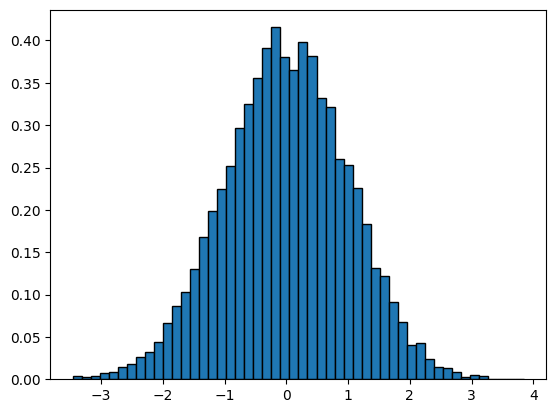

In [20]:
# generate t distribution with sample size 10000
x = stats.t.rvs(df=5030, size=10000)

# create plot of t distribution
plt.hist(x, density=True, edgecolor="black", bins=50)

We can also use the `ttest_ind` method to determine the probability that our returns came from the same sample distribution as in above figure


In [21]:
t_stat, p = stats.ttest_ind(df["SP500"], stats.t.rvs(df=5030, size=5031))
print(f"t={t_stat}, p={p}")

t=-0.20680583313400858, p=0.8361656854653299


Here, we get a p-value of 0.836, which means we would reject the null hypothesis at a 95% confidence level that these values come from the same data as the sample. There are two main things to point out here:

* While the p-value is less than 0.95, it’s still not too far off, and it's magnitudes closer to being true than the normal distribution we showed before. This indicates that this distribution is much better to use when modeling daily returns than the normal distribution. 
* This p-value is highly reliant on the sample data we have here. Every time we run that cell, we get different sample data, which also means different p-values. 

## 4. Conclusion

In this lesson, we focused for the first time on comparing daily stock return data to normal distributions. We also touched on other potential distributions we could use to model this data. In the next module, we will take what we've learned thus far and apply it to a portfolio setting instead of just looking at individual assets in isolation

**References**

- D'Agostino, Ralph B. “An Omnibus Test of Normality for Moderate and Large Size Samples.” *Biometrika*, vol. 58, no. 2, 1971, pp. 341–348, https://doi.org/10.1093/biomet/58.2.341.